In [ ]:
import warnings

import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn import metrics, model_selection, pipeline
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/transform/df_engineered.csv')
df_tst = pd.read_csv('../data/transform/df_engineered_tst.csv')

In [3]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 39 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   player_rating_home_player_1                                                              3040 non-null   int64  
 1   player_rating_home_player_9                                                              3040 non-null   int64  
 2   player_rating_home_player_10                                                             3040 non-null   int64  
 3   player_rating_away_player_10                                                             3040 non-null   int64  
 4   player_rating_away_player_11                                                             3040 non-null   int64  
 5   away_team_ewm_goals                                           

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 39 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   player_rating_home_player_1                                                              3040 non-null   int64  
 1   player_rating_home_player_9                                                              3040 non-null   int64  
 2   player_rating_home_player_10                                                             3040 non-null   int64  
 3   player_rating_away_player_10                                                             3040 non-null   int64  
 4   player_rating_away_player_11                                                             3040 non-null   int64  
 5   away_team_ewm_goals                                           

In [5]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(df.drop(['result_match'], axis=1), df['result_match'], test_size=.2, random_state=42)

X_test = df_tst.loc[:600].drop('result_match', axis=1)
y_test = df_tst.loc[:600]['result_match']

In [6]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2432, 38)
y_train shape: (2432,)
X_val shape: (608, 38)
y_val shape: (608,)
X_test shape: (601, 38)
y_test shape: (601,)


In [7]:
# Initialize the XGBClassifier
cfl = xgb.XGBClassifier(random_state=42)

# Train the model on the full feature set
cfl.fit(X_train, y_train)
y_pred = cfl.predict(X_val)

f1 = f1_score(y_val, y_pred, average='weighted')

print(f1)

0.5329124249890244


In [8]:
xg_oob = xgb.XGBClassifier()
xg_oob.fit(X_train, y_train)
xg_oob.score(X_val, y_val)

0.5427631578947368

In [9]:
# Let's try w/ depth of 2 and 2 trees
xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)
xg2.fit(X_train, y_train)
xg2.score(X_val, y_val)

0.5608552631578947

In [10]:
# import dtreeviz

# X_train = X_train.dropna()
# indices_to_drop = X_train.index.difference(X_train.index)
# y_train = y_train.drop(indices_to_drop)

# viz = dtreeviz.model(xg2, X_train=X_train, y_train=y_train, target_name='result_match',
#                      feature_names=list(X_train.columns),
#                      class_names=['Away win', 'Draw', 'Home win'], tree_index=1)
# viz.view(depth_range_to_display=[0,2])

In [11]:
xg = xgb.XGBClassifier(early_stopping_rounds=20)
xg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_val, y_val)]
      )
xg.score(X_test, y_test)

[0]	validation_0-mlogloss:1.00669	validation_1-mlogloss:1.05226
[1]	validation_0-mlogloss:0.93699	validation_1-mlogloss:1.01929
[2]	validation_0-mlogloss:0.88245	validation_1-mlogloss:1.00540
[3]	validation_0-mlogloss:0.83384	validation_1-mlogloss:0.99840
[4]	validation_0-mlogloss:0.79957	validation_1-mlogloss:0.99397
[5]	validation_0-mlogloss:0.76691	validation_1-mlogloss:0.99125
[6]	validation_0-mlogloss:0.74154	validation_1-mlogloss:0.99133
[7]	validation_0-mlogloss:0.71510	validation_1-mlogloss:0.99098
[8]	validation_0-mlogloss:0.69878	validation_1-mlogloss:0.98944
[9]	validation_0-mlogloss:0.67499	validation_1-mlogloss:0.99099
[10]	validation_0-mlogloss:0.66438	validation_1-mlogloss:0.99025
[11]	validation_0-mlogloss:0.65466	validation_1-mlogloss:0.98995
[12]	validation_0-mlogloss:0.64130	validation_1-mlogloss:0.98909
[13]	validation_0-mlogloss:0.61813	validation_1-mlogloss:0.99446
[14]	validation_0-mlogloss:0.60151	validation_1-mlogloss:0.99632
[15]	validation_0-mlogloss:0.58331	

0.7720465890183028

In [12]:
xg.best_iteration

12

Text(0.5, 0, 'ntrees')

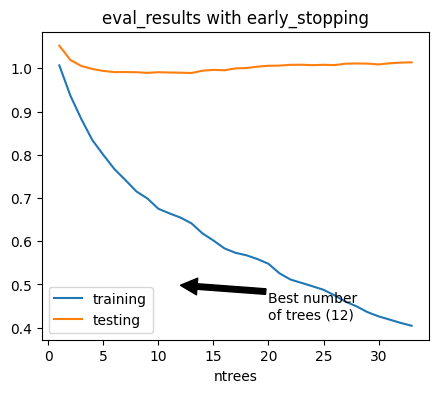

In [13]:
# Testing score is best at 13 trees
results = xg.evals_result()
fig, ax = plt.subplots(figsize=(8, 4))
ax = (pd.DataFrame({'training': results['validation_0']['mlogloss'],
                    'testing': results['validation_1']['mlogloss']})
      .assign(ntrees=lambda adf: range(1, len(adf)+1))
      .set_index('ntrees')
      .plot(figsize=(5,4), ax=ax,title='eval_results with early_stopping')
     )

ax.annotate('Best number \nof trees (12)', xy=(12, .498),
xytext=(20,.42), arrowprops={'color':'k'})
ax.set_xlabel('ntrees')

In [14]:
# No early stopping, uses all estimators
xg_no_es = xgb.XGBClassifier()
xg_no_es.fit(X_train, y_train)
xg_no_es.score(X_val, y_val)

0.5427631578947368

In [15]:
# One convention
# is that hyperparameters that start with max_ will tend to complicate the model (and lead to
# overfitting) when you raise the value. Conversely, they will simplify the model if you lower
# them (and lead to underfitting). Often there is a sweet spot in between

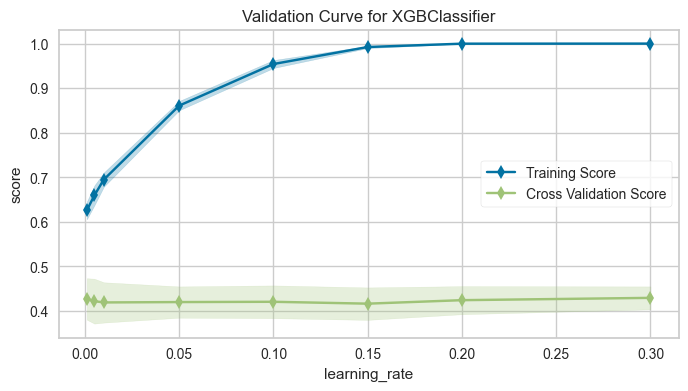

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,...
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                n_jobs=-1, param_name='learning_rate',
                param_range=array([0.001, 0.005, 0.01 , 0.05 , 0.1  , 0.15 , 0.2  , 0.3  ]),
                scoring='f1_weighted')

In [16]:
from yellowbrick import model_selection as ms

fig, ax = plt.subplots(figsize=(8, 4))
# ms.validation_curve(xgb.XGBClassifier(), df.drop(['result_match'], axis=1), df['result_match'], param_name='gamma',
#                     param_range=[0, .5, 1,5,10, 20, 30], n_jobs=-1, ax=ax, scoring="f1_weighted")

ms.validation_curve(xgb.XGBClassifier(), df.drop(['result_match'], axis=1), df['result_match'], param_name='learning_rate',
                    param_range=[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3], n_jobs=-1, ax=ax, scoring="f1_weighted")

# This validation curve poses two possibilities: first, 
# that we do not have the correct param_range to find the best k and need to expand our search to larger values. 
# The second is that other hyperparameters (such as uniform or distance based weighting, or even the distance metric)
# may have more influence on the default model than k by itself does.
# Although validation curves can give us some intuition about the performance of a model to a single hyperparameter, 
# grid search is required to understand the performance of a model with respect to multiple hyperparameters.

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                          X_train: pd.DataFrame, y_train: pd.Series,
                          X_test: pd.DataFrame, y_test: pd.Series,
                          early_stopping_rounds: int=50,
                          metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value is 50.
    metric : callable
        Metric to maximize. Default is accuracy
        Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """

    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),(X_test, y_test)]
    model.fit(X_train, y_train,eval_set=evaluation,verbose=False)
    pred = model.predict(X_test)
    score = metric(y_test, pred, average='weighted')
    return {'loss': 1-score, 'status': STATUS_OK, 'model': model}


In [ ]:
from hyperopt import hp, pyll

uniform_vals = [pyll.stochastic.sample(hp.loguniform('value', -4, 0))
    for _ in range(10_000)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals)

In [ ]:
options = {'max_depth': hp.quniform('max_depth', 6, 22, 2), # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -5, 0), # boosting
    'random_state': 42
}

trials = Trials()
# Pass X_train and y_train to the hyperparameter_tuning function
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_val, y_val, 120, f1_score), space=options, algo=tpe.suggest, max_evals=2000, trials=trials)

print("Best Hyperparameters:", best)

In [ ]:
best_hyperparameters_1 = {
    'colsample_bytree': 0.7402689253639231,
    'gamma': 0.0028348541499777537,
    'learning_rate': 0.1752060870921795,
    'max_depth': 6,
    'min_child_weight': 3.0532978217490725,
    'reg_alpha': 4.390442958079982,
    'reg_lambda': 5.821841964093785,
    'subsample': 0.68327049590758
}

best_hyperparameters_2 = {
    'colsample_bytree': 0.7692485988189818,
     'gamma': 0.00012070096616614979,
     'learning_rate': 0.001554370091231591,
     'max_depth': 12,
     'min_child_weight': 1.0584548941145138,
     'reg_alpha': 0.0029253070004006676,
     'reg_lambda': 6.230782615668019,
     'subsample': 0.9619535988644129
}


best_hyperparameters_3 = {
    'colsample_bytree': 0.9206694651571061,
    'gamma': 0.00042191775548186306,
    'learning_rate': 0.3948078011409823,
    'max_depth': 6,
    'min_child_weight': 4.239951535915615,
    'reg_alpha': 9.331451879784092,
    'reg_lambda': 9.243205902587139,
    'subsample': 0.9487693920624407
}

In [ ]:
xg_ex = xgb.XGBClassifier(**best_hyperparameters_2, early_stopping_rounds=100, n_estimators=500)
xg_ex.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
xg_ex.score(X_val, y_val)

(array([4586., 1539.,  935.,  683.,  543.,  494.,  374.,  324.,  271.,
         251.]),
 array([0.01831796, 0.11642654, 0.21453512, 0.3126437 , 0.41075228,
        0.50886086, 0.60696944, 0.70507802, 0.8031866 , 0.90129518,
        0.99940376]),
 <BarContainer object of 10 artists>)

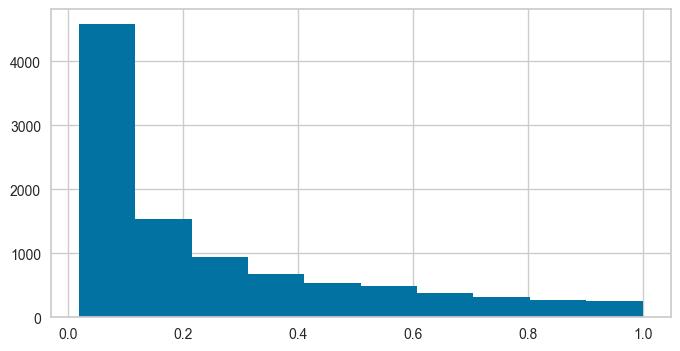

In [43]:
from hyperopt import hp, pyll

uniform_vals = [pyll.stochastic.sample(hp.loguniform('value', -4, 0))
    for _ in range(10_000)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals)

In [21]:
options = {'max_depth': hp.quniform('max_depth', 6, 22, 2), # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -5, 0), # boosting
    'random_state': 42
}

trials = Trials()
# Pass X_train and y_train to the hyperparameter_tuning function
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_val, y_val, 120, f1_score), space=options, algo=tpe.suggest, max_evals=2000, trials=trials)

print("Best Hyperparameters:", best)

100%|██████████| 2000/2000 [58:11<00:00,  1.75s/trial, best loss: 0.4588295102635115]  
Best Hyperparameters: {'colsample_bytree': 0.7692485988189818, 'gamma': 0.00012070096616614979, 'learning_rate': 0.001554370091231591, 'max_depth': 12.0, 'min_child_weight': 1.0584548941145138, 'reg_alpha': 0.0029253070004006676, 'reg_lambda': 6.230782615668019, 'subsample': 0.9619535988644129}


In [24]:
best_hyperparameters_1 = {
    'colsample_bytree': 0.7402689253639231,
    'gamma': 0.0028348541499777537,
    'learning_rate': 0.1752060870921795,
    'max_depth': 6,
    'min_child_weight': 3.0532978217490725,
    'reg_alpha': 4.390442958079982,
    'reg_lambda': 5.821841964093785,
    'subsample': 0.68327049590758
}

best_hyperparameters_2 = {
    'colsample_bytree': 0.7692485988189818,
     'gamma': 0.00012070096616614979,
     'learning_rate': 0.001554370091231591,
     'max_depth': 12,
     'min_child_weight': 1.0584548941145138,
     'reg_alpha': 0.0029253070004006676,
     'reg_lambda': 6.230782615668019,
     'subsample': 0.9619535988644129
}


best_hyperparameters_3 = {
    'colsample_bytree': 0.9206694651571061,
    'gamma': 0.00042191775548186306,
    'learning_rate': 0.3948078011409823,
    'max_depth': 6,
    'min_child_weight': 4.239951535915615,
    'reg_alpha': 9.331451879784092,
    'reg_lambda': 9.243205902587139,
    'subsample': 0.9487693920624407
}

In [38]:
xg_ex = xgb.XGBClassifier(**best_hyperparameters_2, early_stopping_rounds=100, n_estimators=500)
xg_ex.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
xg_ex.score(X_val, y_val)

[0]	validation_0-mlogloss:1.09787	validation_1-mlogloss:1.09800
[100]	validation_0-mlogloss:1.02753	validation_1-mlogloss:1.03968
[200]	validation_0-mlogloss:0.96461	validation_1-mlogloss:0.98797
[300]	validation_0-mlogloss:0.90761	validation_1-mlogloss:0.94143
[400]	validation_0-mlogloss:0.85580	validation_1-mlogloss:0.89896
[499]	validation_0-mlogloss:0.80873	validation_1-mlogloss:0.86088


0.5526315789473685